In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import inv, LinearOperator, cg


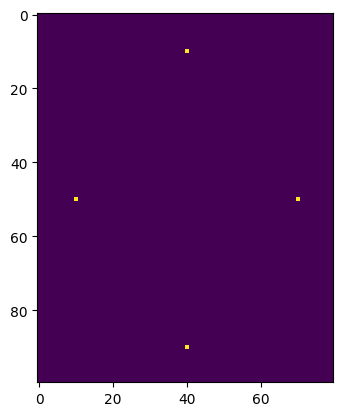

In [9]:
width, height, accuracy, resistance = 80, 100, 1e-4, 1
contacts = [
    (0, -40, 1.1),  # x, y, potential
    (0, 40, 1.1),
    (-30, 0, 1.1),
    (30, 0, 1.1), ]


def configure_plate(width, height, contacts):
    plate = np.zeros((height, width))
    for x, y, potential in contacts:
        plate[y + height // 2, x + width // 2] = potential  # add offsets to x and y
    return plate


plate = configure_plate(
    width=width,
    height=height,
    contacts=contacts, )

plt.imshow(plate)

In [10]:
def jacobi(A):
    d = A.diagonal()
    D = diags(d).tocsc()  # convert D to CSC format
    M_inv = inv(D)
    return M_inv

In [11]:
def solve_poisson(plate, resistance, accuracy):
    """
    Solve the Poisson equation for a plate with the given resistance and accuracy.
    plate is a 2D array of the plate potential. Resistance is the resistance of the plate material. Accuracy is the desired accuracy of the solution.  
    Accuracy is the desired accuracy of the solution.
    :param plate: 
    :param resistance: 
    :param accuracy: 
    :return: 
    return Example:
    """
    height, width = plate.shape  # get the dimensions of the plate
    size = height * width  #  get the total number of points
    conductivity = 1 / resistance  # calculate the conductivity of the plate material (inverse of resistance)  
    main_diag = np.ones(size) * -4 * conductivity  # create the main diagonal of the matrix (4 * conductivity) 
    off_diags = np.ones(size - 1) * conductivity  # create the off diagonals of the matrix (conductivity) 
    diagonals = [main_diag, off_diags, off_diags, off_diags, off_diags]  # create the diagonals of the matrix 
    A = diags(diagonals, [0, -1, 1, -width,
                          width]).tocsr()  # create the matrix A that represents the system of linear equations by using the diagonals and offsets and convert it to CSR format

    # Prepare the RHS vector
    plate_flat = plate.flatten()  # flatten the plate to a 1D array 
    b = -plate_flat  # RHS vector is the negative of the plate potential

    # Enforce boundary conditions
    b[:width] = 0  # set the top row to 0 
    b[-width:] = 0  # set the bottom row to 0
    b[::width] = 0  # set the left column to 0
    b[width - 1:: width] = 0  # set the right column to 0

    # Initial guess for the solution
    solution = np.zeros_like(b)  # create an array of zeros with the same shape as b 

    # Define preconditioner
    M_inv = jacobi(A)  # use the jacobi function to get the inverse of the diagonal matrix 
    M = LinearOperator((size, size),
                       matvec=M_inv.dot)  # create a linear operator that applies the inverse of the diagonal matrix to a vector by matrix multiplication

    while True:  # loop until the solution converges to the desired accuracy 
        # Solve the system of linear equations using the conjugate gradient method
        new_solution, _ = cg(A, b + A.dot(solution), x0=solution, tol=accuracy,
                             M=M)  # use the conjugate gradient method to solve the system of linear equations and get the new solution
        diff = np.linalg.norm(
            new_solution - solution)  # calculate the difference between the new solution and the previous solution 

        if diff < accuracy:  # check if the difference is less than the desired accuracy 
            break  # if the difference is less than the desired accuracy, break out of the loop
        solution = new_solution  # if the difference is not less than the desired accuracy, set the new solution to the solution variable and continue the loop and solve the system of linear equations again

    return solution.reshape((height, width))  # reshape the solution to the shape of the plate and return it 

In [12]:
def plot_results(plate, x, y, E_x, E_y, contacts, width, height, title=''):
    fig, ax = plt.subplots(1, 2, figsize=(16, 7))

    contour = ax[0].contourf(x, y, plate, cmap="hot")
    for contact in contacts:
        ax[0].plot(contact[0] + width // 2, contact[1] + height // 2, "wo")
    ax[0].set_xlim([-width // 2, width // 2])
    ax[0].set_ylim([-height // 2, height // 2])
    fig.colorbar(contour, ax=ax[0], label="Potential")
    ax[0].set_title(f"Electric Potential ({title})")

    ax[1].quiver(x, y, E_x, E_y, scale=5)
    for contact in contacts:
        ax[1].plot(contact[0] + width // 2, contact[1] + height // 2, "wo")
    ax[1].set_xlim([-width // 2, width // 2])
    ax[1].set_ylim([-height // 2, height // 2])
    ax[1].set_title(f"Electric Field ({title})")

    plt.show()



In [13]:
def calculate_field(plate):
    gradient = np.gradient(plate)
    E_y, E_x = -gradient[0], -gradient[1]
    return E_x, E_y


resistances = np.linspace(1, 4, num=5)

temp_list = []

for resistance in resistances:
    conductivity = 1 / resistance
    plate = solve_poisson(plate, conductivity, 1e-4)
    E_x, E_y = calculate_field(plate)
    y, x = np.mgrid[-height // 2: height // 2, -width // 2: width // 2]
    temp_list.append((plate, x, y, E_x, E_y))
    # plot_results(plate, x, y, E_x, E_y, contacts, width, height, title=f'Resistance = {resistance}')

temp_list = np.array(temp_list)
temp_list


array([[[[ 1.02547215e+01,  1.39590864e+01,  1.55156864e+01, ...,
           2.05628957e+01,  2.13664507e+01,  2.29844109e+01],
         [ 2.72499101e+01,  3.02362840e+01,  3.20120609e+01, ...,
           4.09920925e+01,  4.20754762e+01,  4.35898999e+01],
         [ 4.58812328e+01,  4.79763598e+01,  4.95289287e+01, ...,
           6.12929535e+01,  6.23685043e+01,  6.35792944e+01],
         ...,
         [ 6.77852628e+01,  6.65840572e+01,  6.56581264e+01, ...,
           5.31093069e+01,  5.16568480e+01,  4.95167294e+01],
         [ 4.69629584e+01,  4.53783819e+01,  4.43973063e+01, ...,
           3.45875034e+01,  3.28232738e+01,  2.96389215e+01],
         [ 2.49840185e+01,  2.32281927e+01,  2.24402298e+01, ...,
           1.68447416e+01,  1.52150566e+01,  1.12285271e+01]],

        [[-4.00000000e+01, -3.90000000e+01, -3.80000000e+01, ...,
           3.70000000e+01,  3.80000000e+01,  3.90000000e+01],
         [-4.00000000e+01, -3.90000000e+01, -3.80000000e+01, ...,
           3.70000000e

In [14]:
# Visualisation

